# Installing and Importing Libraries

In [1]:
!pip install pandas==1.2.2
!pip install kaggle

     |████████████████████████████████| 9.9 MB 31.1 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.2.2 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#Dataset I : Simple Forecasting using LSTM

In [3]:
#Download the dataset 

!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

--2021-09-30 11:51:56--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2021-09-30 11:51:57 (36.6 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



In [4]:
# Read the files into a pandas DataFrame and visualize the data. 
training_set = pd.read_csv('/content/airline-passengers.csv')
print(training_set)

       Month  Passengers
0    1949-01         112
1    1949-02         118
2    1949-03         132
3    1949-04         129
4    1949-05         121
..       ...         ...
139  1960-08         606
140  1960-09         508
141  1960-10         461
142  1960-11         390
143  1960-12         432

[144 rows x 2 columns]


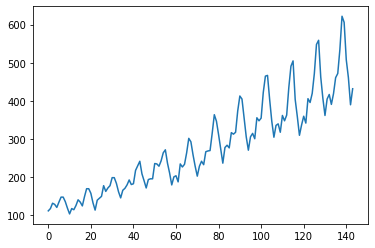

In [5]:
# observe the parameter of interest over time for trend and sensonality aspects.  
training_set = training_set.iloc[:,1:2].values
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

In [6]:
# Make sequences from the given data and split them into train and test sets. 
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [7]:
# Defining an LSTM network followed by a fully connected layer. 
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out


In [10]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1 # number of features per sample
hidden_size = 2 
num_layers = 1  # no. of LSTM blocks you require (>1 makes it a stacked LSTM). In case of stacked LSTMs your hidden_size parameter will be list of values.

num_classes = 1 # = the number of items you are prediction for a particular time. (usually = 1)

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad() # clead the previous gradients before calculating new ones.
    
    # obtain the loss function
    loss = criterion(outputs, trainY) # compute the loss
    
    loss.backward() # back propagate and compute the gradients.
    
    optimizer.step() #update the weights. 
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.10723
Epoch: 100, loss: 0.01651
Epoch: 200, loss: 0.00343
Epoch: 300, loss: 0.00275
Epoch: 400, loss: 0.00222
Epoch: 500, loss: 0.00188
Epoch: 600, loss: 0.00174
Epoch: 700, loss: 0.00172
Epoch: 800, loss: 0.00171
Epoch: 900, loss: 0.00170
Epoch: 1000, loss: 0.00169
Epoch: 1100, loss: 0.00169
Epoch: 1200, loss: 0.00168
Epoch: 1300, loss: 0.00167
Epoch: 1400, loss: 0.00167
Epoch: 1500, loss: 0.00166
Epoch: 1600, loss: 0.00165
Epoch: 1700, loss: 0.00165
Epoch: 1800, loss: 0.00164
Epoch: 1900, loss: 0.00163


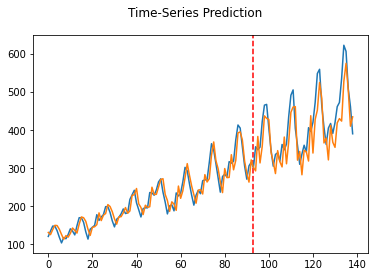

In [11]:
#Evaluating and visualizing the predictions.
lstm.eval() #puts the network/model in evaluation mode (gradients will not be calcualted.)
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

# Dataset II : Future Sales Prediction using LSTM

# Importing Data from Kaggle

In [12]:
! mkdir ~/.kaggle

In [13]:
#you have to login to your kaggle account and download the API token which is used by them to authorize the download of ANY ddataset here.
! cp kaggle.json ~/.kaggle/

In [14]:
!mkdir /content/data

In [15]:
cd /content/data/

/content/data


In [16]:
#every dataset has an associated API command, copy&paste it and run as below.
!kaggle competitions download -c competitive-data-science-predict-future-sales

 38% 5.00M/13.3M [00:00<00:00, 43.0MB/s]
100% 13.3M/13.3M [00:00<00:00, 65.1MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.98MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.48MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 24.6MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 33.9MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 31.2MB/s]


In [17]:
!unzip '/content/data/sales_train.csv.zip'
!unzip '/content/data/items_categories.csv.zip'
!unzip '/content/data/items.csv.zip'
!unzip '/content/data/sample_submission.csv.zip'
!unzip '/content/data/test.csv.zip'

Archive:  /content/data/sales_train.csv.zip
  inflating: sales_train.csv         
unzip:  cannot find or open /content/data/items_categories.csv.zip, /content/data/items_categories.csv.zip.zip or /content/data/items_categories.csv.zip.ZIP.
Archive:  /content/data/items.csv.zip
  inflating: items.csv               
Archive:  /content/data/sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  /content/data/test.csv.zip
  inflating: test.csv                


#Preparing, Loading and Visualizations the Data


In [18]:
path='/content/data/'
df_train = pd.read_csv(path + 'sales_train.csv' ,parse_dates=['date']) #your training data.
df_shops = pd.read_csv(path + 'shops.csv')  # data of shops => a mapping b/w shop id and shops.
df_items = pd.read_csv(path + 'items.csv')  # data of items => a mapping b/w item id and items.
df_item_categories = pd.read_csv(path + 'item_categories.csv') #data of categories => a mapping b/w category id and catergories.


In [19]:
#convert the 'date' column of the dataframe into datetime time. Otherwise they are considered as numbers.
df_train['date'] = pd.to_datetime(df_train['date'], errors='coerce') 

In [20]:
#visualize the 
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [21]:
# change the item count per day to item count per month by using group
df_train = df_train.groupby(["item_id","shop_id","date_block_num"]).sum().reset_index()
df_train = df_train.rename(index=str, columns = {"item_cnt_day":"item_cnt_month"})
df_train = df_train[["item_id","shop_id","date_block_num","item_cnt_month"]]
# df_train

In [22]:
print(df_train)

         item_id  shop_id  date_block_num  item_cnt_month
0              0       54              20             1.0
1              1       55              15             2.0
2              1       55              18             1.0
3              1       55              19             1.0
4              1       55              20             1.0
...          ...      ...             ...             ...
1609119    22168       12               8             1.0
1609120    22168       16               1             1.0
1609121    22168       42               1             1.0
1609122    22168       43               2             1.0
1609123    22169       25              14             1.0

[1609124 rows x 4 columns]


In [21]:
df_train['date_block_num'].describe()

count    1.609124e+06
mean     1.466479e+01
std      9.542322e+00
min      0.000000e+00
25%      6.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64

In [25]:
# Data Loader 
from torch.utils import data
class custom_data_loader(data.Dataset):
  
  def __init__(self, x_list,y_list):
        self.x_list =x_list
        self.y_list =y_list
        # self.seq_length =seq_length
        self.index_counter=0

        
                        
            
  def __len__(self):
        return len(self.x_list)

  def __getitem__(self, index):
        
      index_top_limit=len(self.x_list)
      if(self.index_counter==index_top_limit): self.index_counter=0
      index=self.index_counter
      self.index_counter=self.index_counter+1
      
      
      x_feature=self.x_list[index] 
      y_feature=self.y_list[index]      
      
        
      return x_feature, y_feature



In [23]:
def sliding_windows(xdata,ydata, seq_length):
    x = []
    y = []

    for i in range(len(xdata)-seq_length-1):
        _x = xdata[i:(i+seq_length)]
        _y = ydata[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc1 = MinMaxScaler()
sc2 = MinMaxScaler()
x_training_data = sc1.fit_transform(df_train[["item_id","shop_id","date_block_num"]])
y_training_data = sc2.fit_transform(df_train[["item_cnt_month"]])
seq_length= 12
x ,y= sliding_windows(x_training_data, y_training_data,seq_length)
# y = sliding_windows(y_training_data, seq_length)
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))



<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Train and Test Dataloaders</h1></center>

In [26]:
batch_size = 2048
trainloader = torch.utils.data.DataLoader(custom_data_loader(x_list = trainX, y_list = trainY), 
                                          batch_size=batch_size, num_workers=0, shuffle = False, pin_memory=True)

testloader = torch.utils.data.DataLoader(custom_data_loader(x_list = testX, y_list = testY), 
                                          batch_size=128, num_workers=0, shuffle = False, pin_memory=True)

loader = torch.utils.data.DataLoader(custom_data_loader(x_list = dataX, y_list = dataY), 
                                          batch_size=128, num_workers=0, shuffle = False, pin_memory=True)

In [27]:
num_epochs = 10
learning_rate = 0.0001

input_size = 3
hidden_size = 6
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
  for x,y in trainloader:
    optimizer.zero_grad()
    outputs = lstm(x)
    loss = criterion(outputs, y)
    loss.backward()
      
    optimizer.step()
  if epoch % 1 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.00060
Epoch: 1, loss: 0.00030
Epoch: 2, loss: 0.00015
Epoch: 3, loss: 0.00007
Epoch: 4, loss: 0.00003
Epoch: 5, loss: 0.00001
Epoch: 6, loss: 0.00001
Epoch: 7, loss: 0.00000
Epoch: 8, loss: 0.00000
Epoch: 9, loss: 0.00000


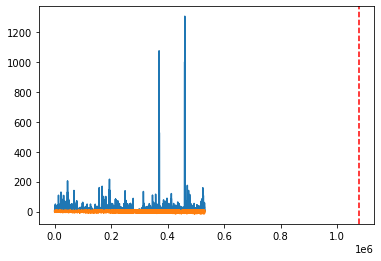

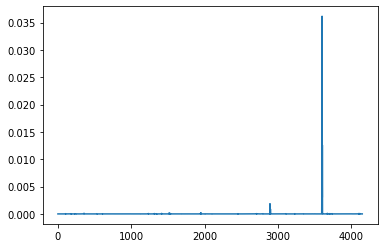

In [39]:
#just predicting and comparing the test set.
lstm.eval()
losses=[]
preds=[]
for x,y in testloader:
  
  outputs = lstm(x)
  loss = criterion(outputs, y)
  losses.append(loss.item())
  preds.extend(outputs)


data_predict = np.array(preds)
dataY_plot = testY.data.numpy()

data_predict = sc2.inverse_transform(data_predict.reshape(-1,1))
dataY_plot = sc2.inverse_transform(dataY_plot.reshape(-1,1))

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.show()  
plt.plot(losses)
plt.show()

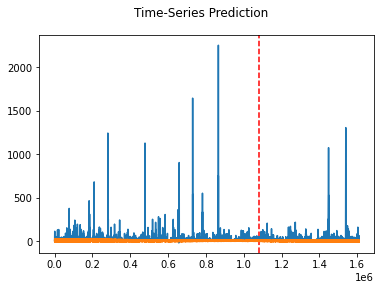

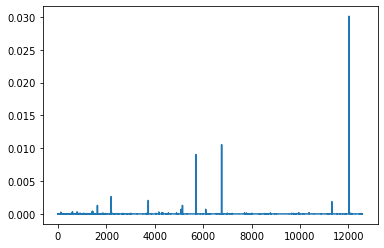

In [40]:
#just predicting and comparing the entire dataset. 
lstm.eval()
losses=[]
preds=[]
for x,y in loader:
  
  outputs = lstm(x)
  loss = criterion(outputs, y)
  losses.append(loss.item())
  preds.extend(outputs)


data_predict = np.array(preds)
dataY_plot = dataY.data.numpy()

data_predict = sc2.inverse_transform(data_predict.reshape(-1,1))
dataY_plot = sc2.inverse_transform(dataY_plot.reshape(-1,1))

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()  
plt.plot(losses)
plt.show()

#Supplementary Materials : latest and quick ways to operate on time series data.



Deep Learning may have taken the front seat in computer vision and language processing tasks but ,even though having outperformed the traditional methods in time series forecasting tasks,deep learning architectures have not become mainstream yet for time series forecasting tasks.Other than the hardware requirements,the lack of a high-level API that would work with popular frameworks like PyTorch or Tensorflow has been a crucial impediment making it relatively difficult to use neural networks over the traditional methods(easy to use in the scikit learn ecosystem)

PyTorch Forecasting solves the problem by providing a high level API for PyTorch that can readily make use of the pandas dataframe.The package is built on PyTorch Lightning and PyTorch APIs,making it easier to learn.

Pytorch Forecasting aims to ease state-of-the-art timeseries forecasting with neural networks for both real-world cases and research alike.Some interesting provisions of the package include:

* A timeseries dataset class which abstracts handling variable transformations, missing values, randomized subsampling, multiple history lengths, etc.So,in short no specific knowledge on how to create a dataset for training your model in PyTorch is required.

* A base model class which provides basic training of timeseries models along with logging in tensorboard and generic visualizations such actual vs predictions and dependency plots

* Multiple neural network architectures for timeseries forecasting that have been enhanced for real-world deployment and come with in-built interpretation capabilities

* Multi-horizon timeseries metrics

* For scalability, the networks are designed to work with PyTorch Lightning which allows training on CPUs and single and multiple (distributed) GPUs out-of-the-box. 

* Hyperparameter tuning with optuna


Source of this part of the Notebook: URL: https://www.kaggle.com/shreyasajal/pytorch-forecasting-for-time-series-forecasting  

In [45]:
#Required Additional Llibraries
!pip install pytorch_forecasting
!pip install pandas==1.2.2 # required to redo as per requirements

  Using cached pandas-1.2.2-cp37-cp37m-manylinux1_x86_64.whl (9.9 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.3
    Uninstalling pandas-1.3.3:
      Successfully uninstalled pandas-1.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-forecasting 0.9.1 requires pandas<2.0.0,>=1.3.0, but you have pandas 1.2.2 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.2.2 which is incompatible.


In [46]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


This is a very important step and some prerequisites for defining a TimeSeriesDaataSet object is that our pandas dataframe must have each row such that they can be identified with a time step and a time series. Fortunately, most datasets are already in this format.In our Datafarme, the time step is defined by the date_block_num column,i.e. for every shop-item combination we have item count values for the months,and our test data wants us to predict the values for one month for all such shop-item combinations.

Some of the important parameters while defining the training object are:
* **min/max encoder length**:the mininmum and maximum lengths for encoding or the history length,for example if there are 20 time steps in total and we want a min encoder length=3 and max encoder length=8,then several sequences will be generated which are at least of length min_encoder_length and at most of length max_encoder_length and generally as large history as possible will be used.The advantage of this flexibility in the length is :If your dataset has also very short time series to predict, this flexibility ensures you can make predictions for these as well while using more history for longer time series.
* **min/max prediction length**:minimum/maximum prediction/decoder length 
* **group ids**:list of column names identifying a time series. This means that the group_ids identify a sample together with the time_idx. If you have only one timeseries, set this to the name of column that is constant.

For better understanding,refer to the [documentation](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.data.timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries.TimeSeriesDataSet)

In [47]:
#Using TimeSeries Dataset to prepare the data directly from the DF. Later we use the same dataset and a loader to load it.
max_prediction_length = 1
max_encoder_length = 27
training_cutoff = df_train['date_block_num'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_train[lambda x: x['date_block_num'] <= training_cutoff],
    time_idx='date_block_num',
    target="item_cnt_month",
    group_ids=["shop_id", "item_id"],
    min_encoder_length=0,  
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=["shop_id", "item_id"],
    time_varying_known_categoricals=[],  
    time_varying_known_reals=['date_block_num'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['date_block_num'],
    categorical_encoders={'shop_id': pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),'item_id':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True)},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
    
)



In [48]:
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [49]:
# configure network and trainer
pl.seed_everything(42)

trainer = pl.Trainer(
    gpus=0, # set to number of GPUs if you are connected to a GPU instance.
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss=pytorch_forecasting.metrics.RMSE(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 19.4k


<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Use Lightning for suggesting a suitable learning rate </h1></center>

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:818: LightningDeprecationWarning:

`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork    

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at /content/data/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /content/data/lr_find_temp_model.ckpt


suggested learning rate: 4.5708818961487505e-07


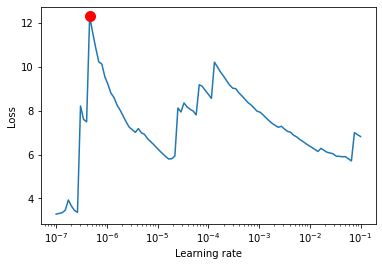

In [50]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-7,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Callbacks ,Trainer and final Model</h1></center>

In [51]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-7, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs") 

trainer = pl.Trainer(
    max_epochs=2,
    gpus=0, #set the number of GPUS (if you are running the notebook on a GPU Instance/Device)
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=5e-7,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1, 
    loss=pytorch_forecasting.metrics.RMSE(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 19.4k


<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Fit the model</h1></center>

In [52]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:531: LightningDeprecationWarning:

`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork      

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Load the best model from Lightning checkpoint</h1></center>

In [53]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Get the validation RMSE</h1></center>

In [54]:
# calcualte root mean squared error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)

In [ ]:
plt.plot(val_predictions)
plt.show()
plt.plot(actuals)

In [55]:
criterion = nn.MSELoss()
torch.sqrt(criterion(actuals,val_predictions))

tensor(7.2349)

<center><h1 style = "font-size:20px;font-family: Comic Sans MS">Predict on the test data</h1></center>

In [56]:
df_test = pd.read_csv(path+'/test.csv')
df_test=df_test.drop(['ID'],axis=1)
df_test['date_block_num']=34
df_test['item_cnt_month']=0
# decoder_data=df_test
# encoder_data = df_train[lambda x: x.date_block_num > x.date_block_num.max() - max_encoder_length]
# new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
pred,x=best_tft.predict(df_test,return_x=True)

In [57]:
# To use GPUS 
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
device

#then you can just do variable_name.to(device) to push the data on to GPU
# and similarly for models also => model.to(device). 
#this code with above additions will push the data onto GPUs/if available else it will retain it on CPU. 

Using PyTorch version: 1.9.0+cu102 CUDA: False


device(type='cpu')